# Cáncer mamario

Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predica de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria.

### Preparar el ambiente de trabajo
- Se importa todas las librerías a utilizar.
  
- Se fijan los parámetros de los gráficos con `plt.Rcparams`.
  
- Se excluyen las columnas `id` y `Unnamed: 32` de la base de datos.
  
- Se recodifica el vector objetivo `diagnosis` a numérico para poder procesarlo posteriormente.


In [10]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Fijar los parámetros de los gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Importar la base de datos y eliminar las columnas id y Unnamed: 32
df = pd.read_csv('breast_cancer.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)

# Recodificar el vector objetivo diagnosis a numérico
df['diagnosis'] = np.where(df['diagnosis'] == 'M', 1, 0)

### Visualizando la distribución de los atributos
- Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
- Se agregan las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

C:\Users\javit\AppData\Local\Temp\ipykernel_8180\3141657781.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


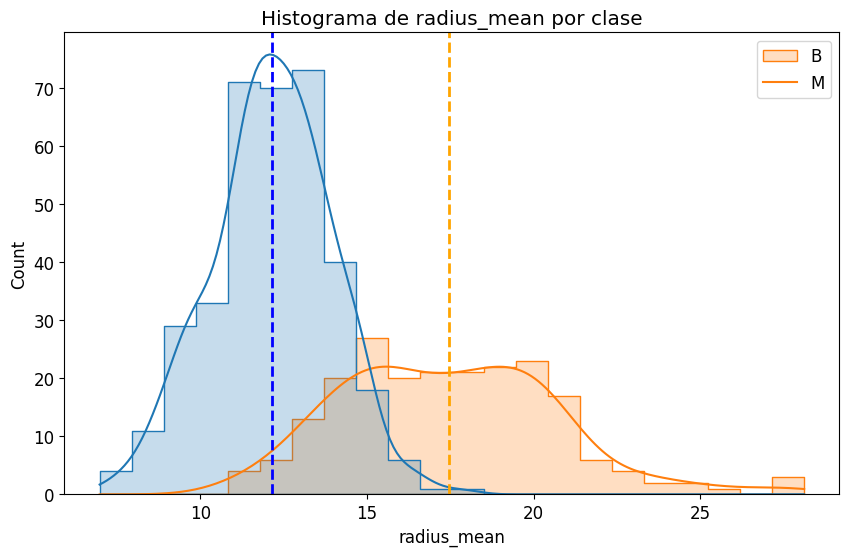

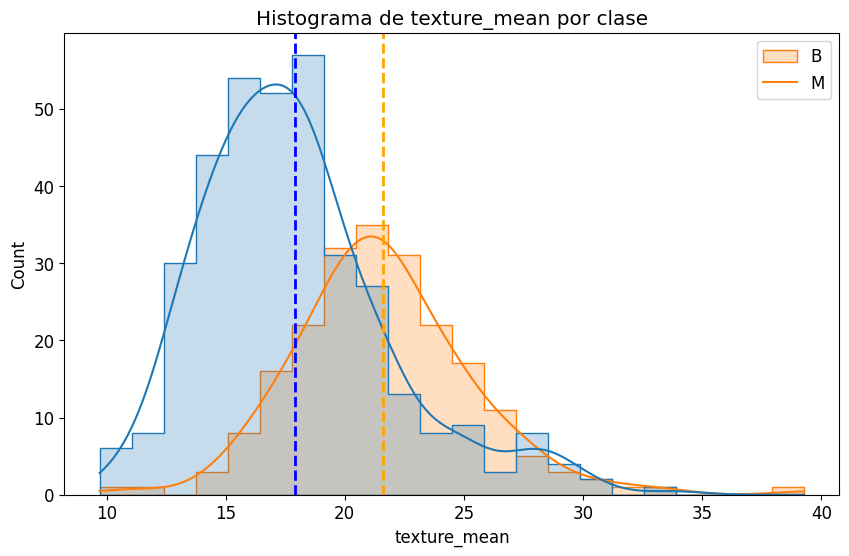

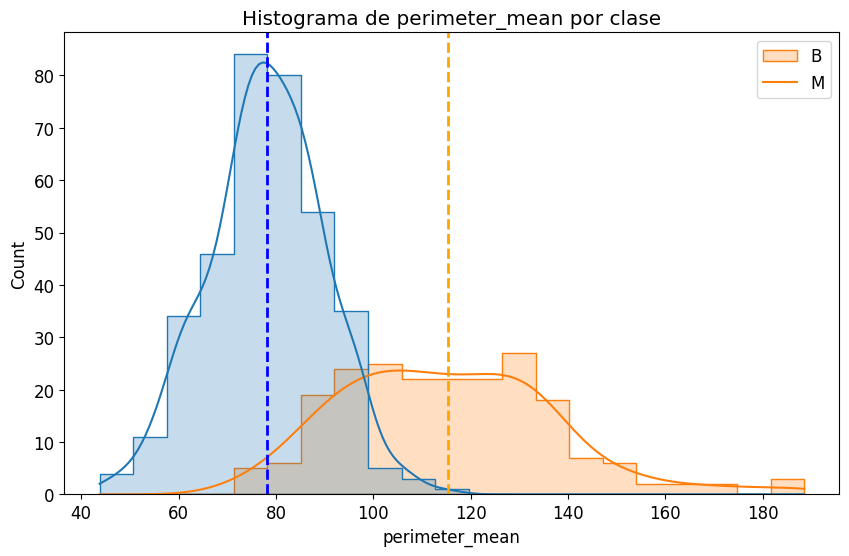

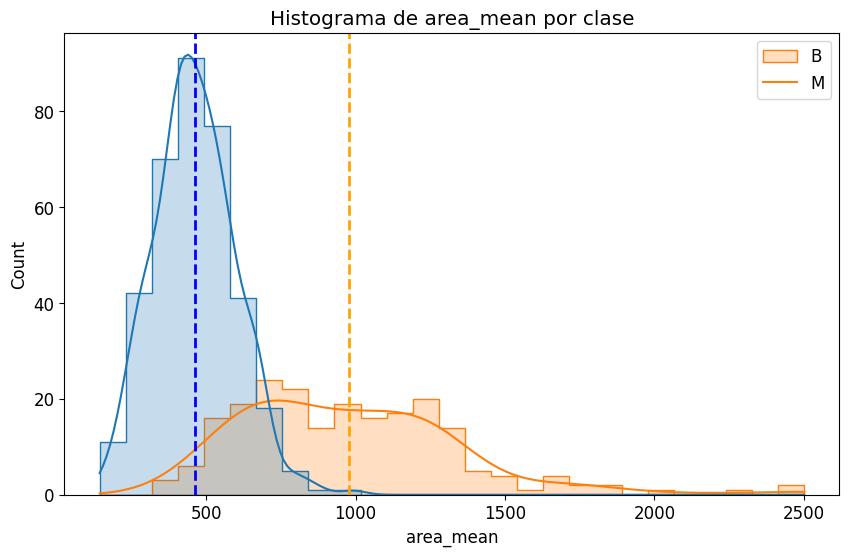

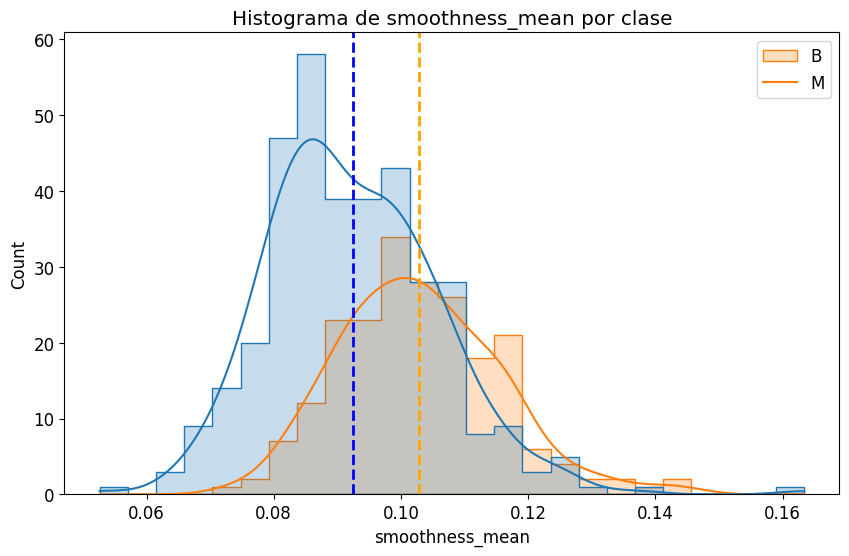

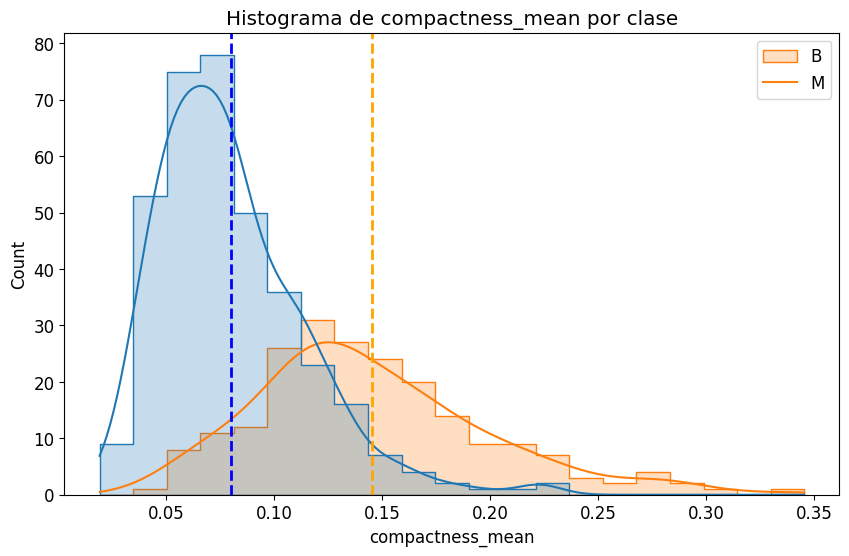

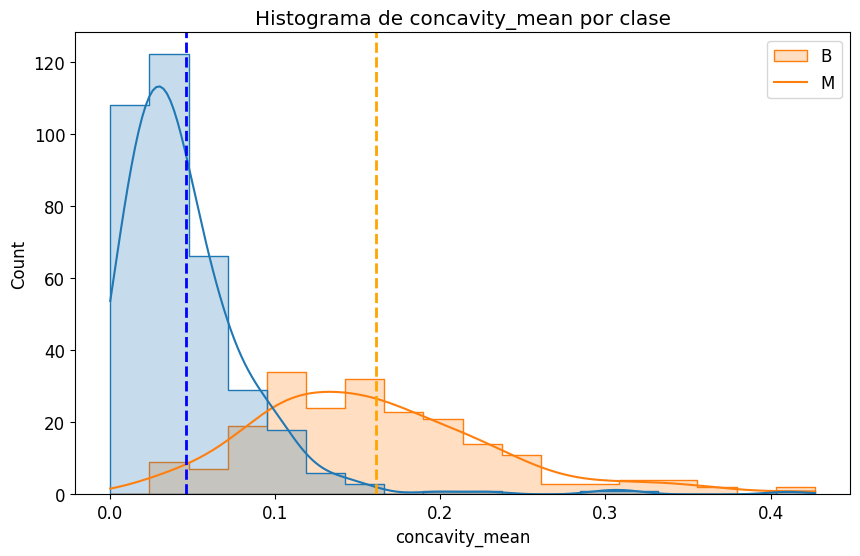

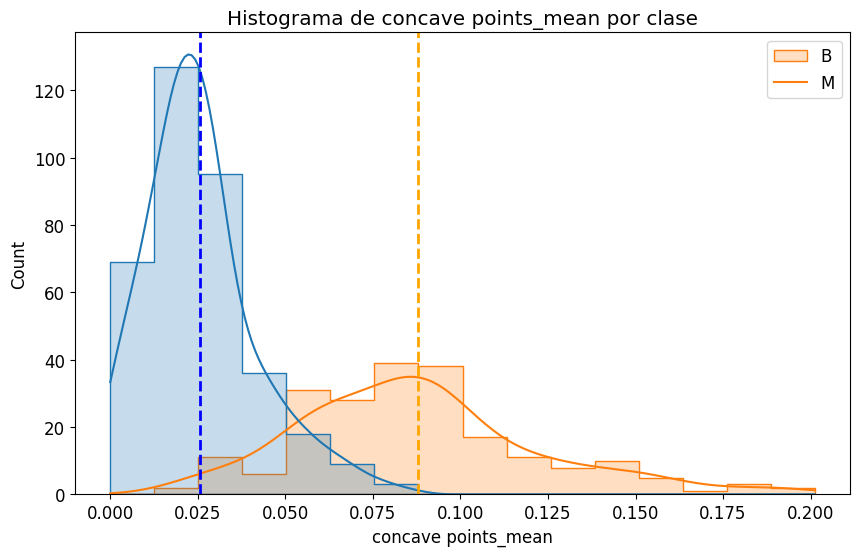

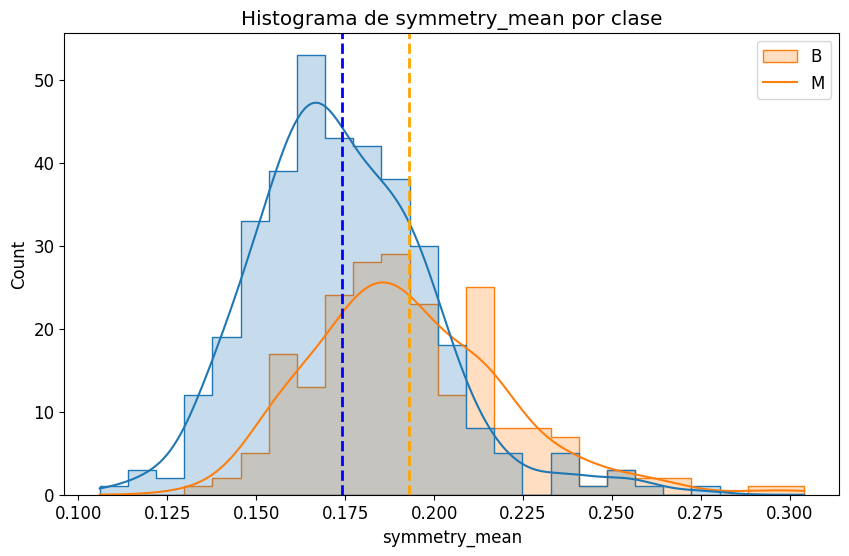

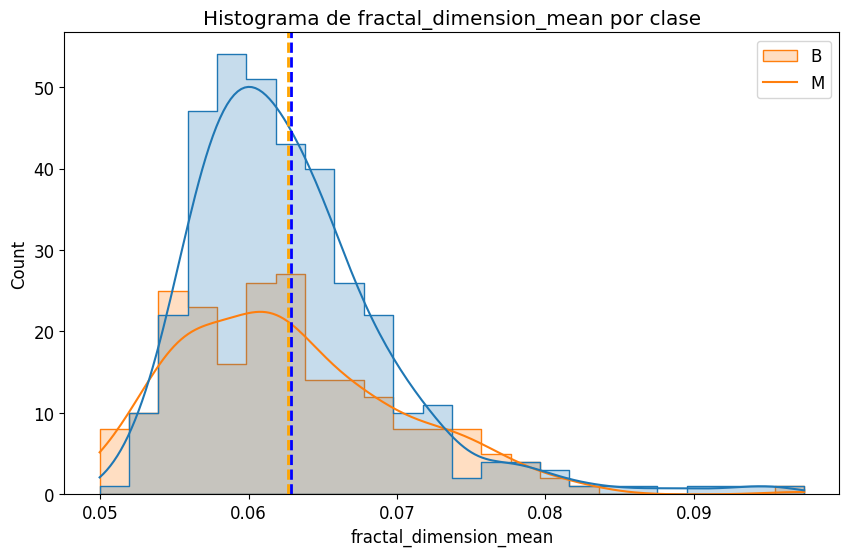

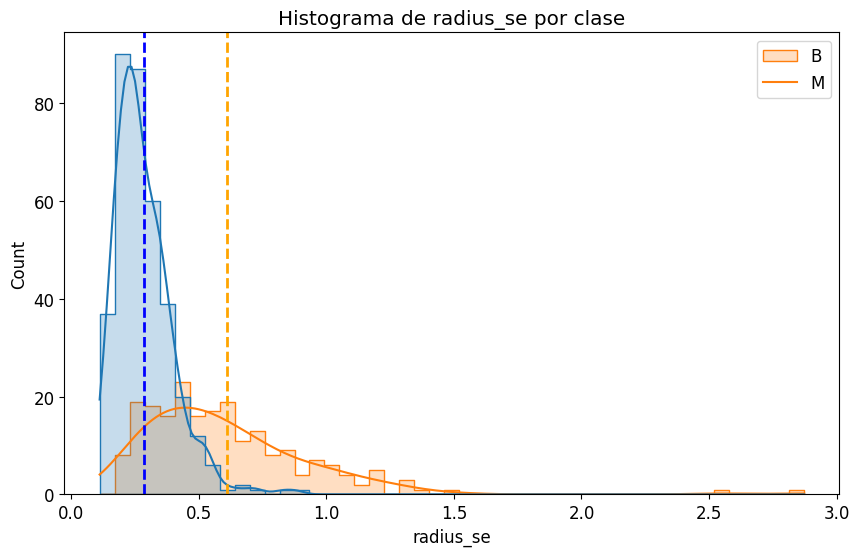

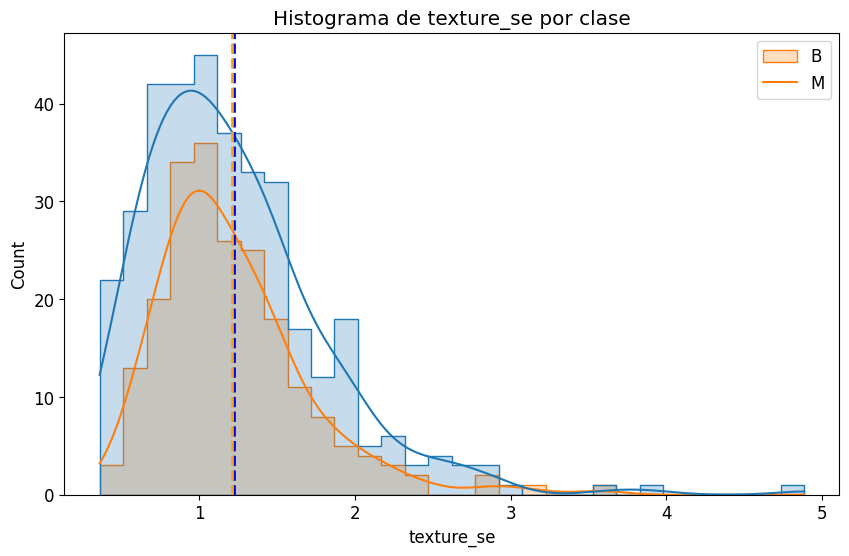

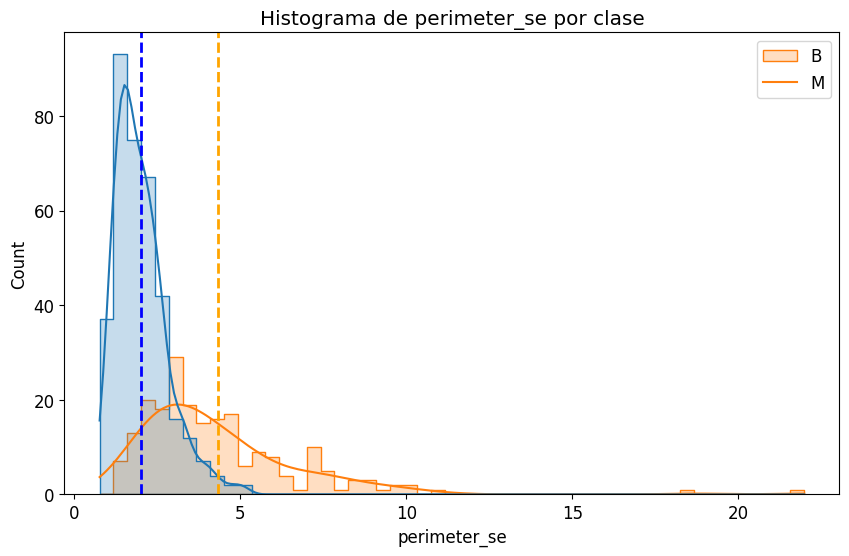

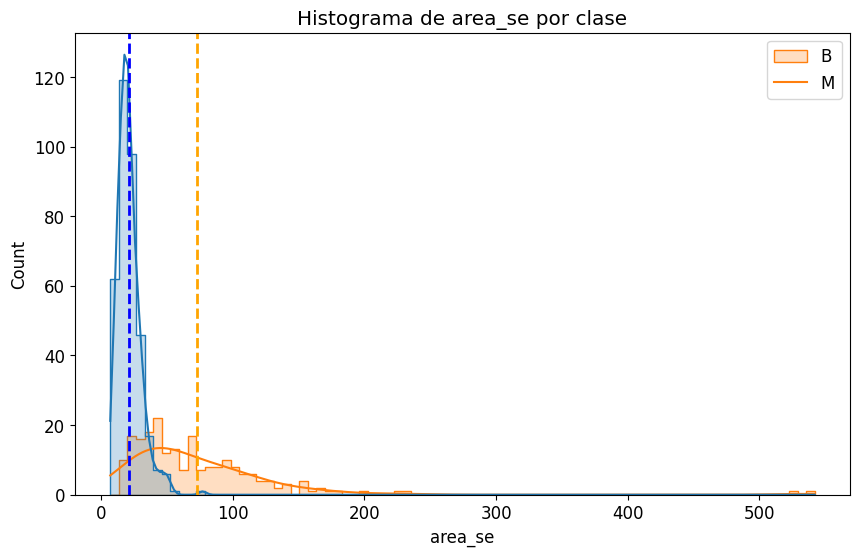

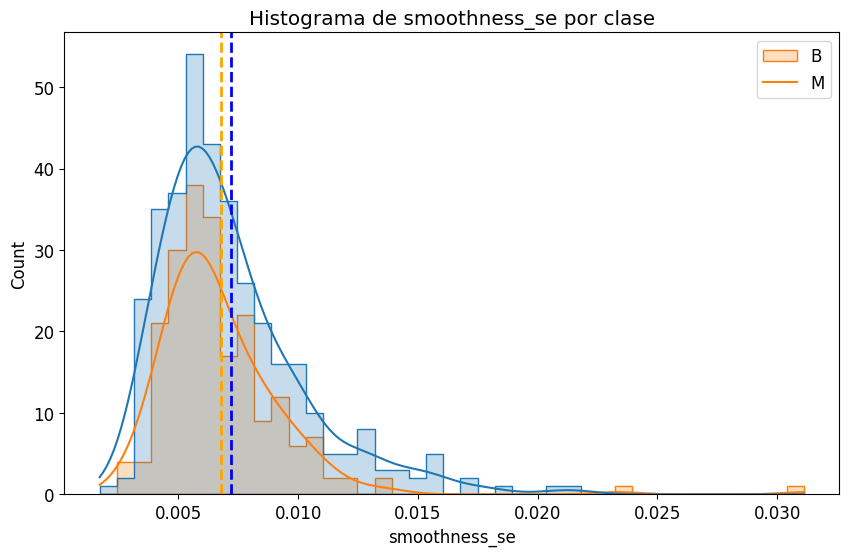

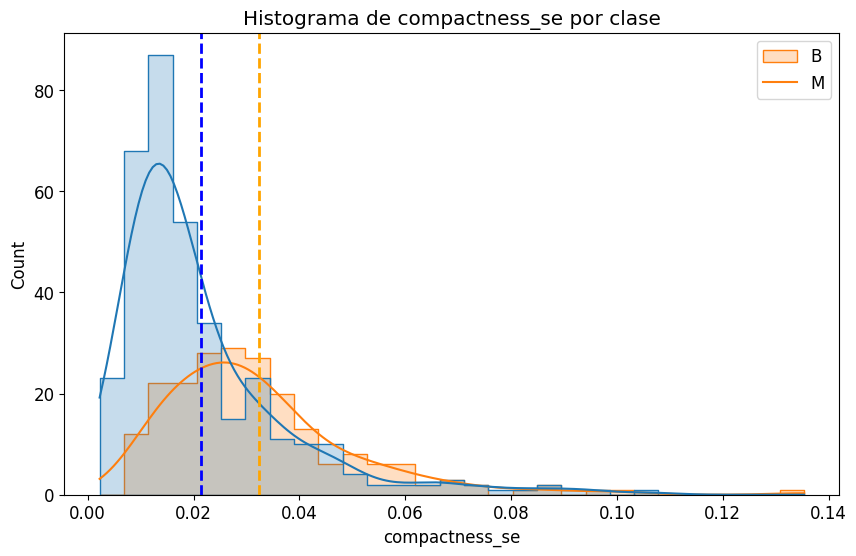

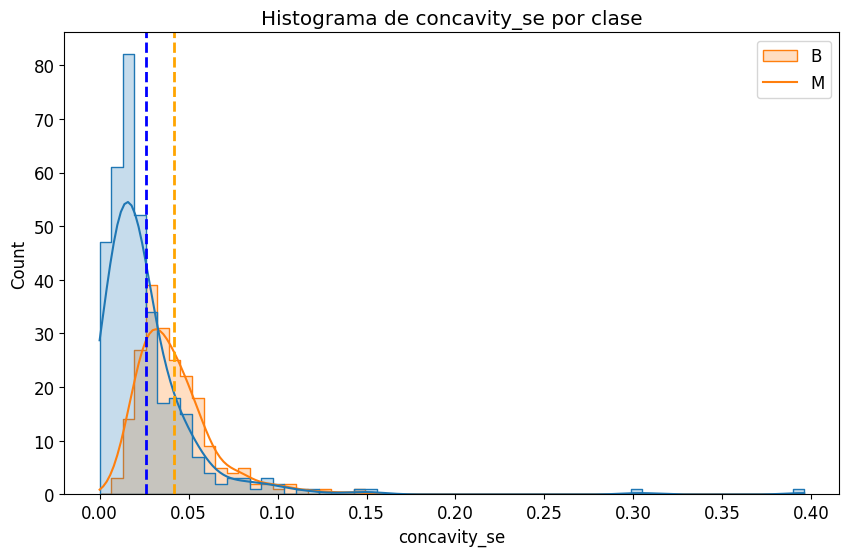

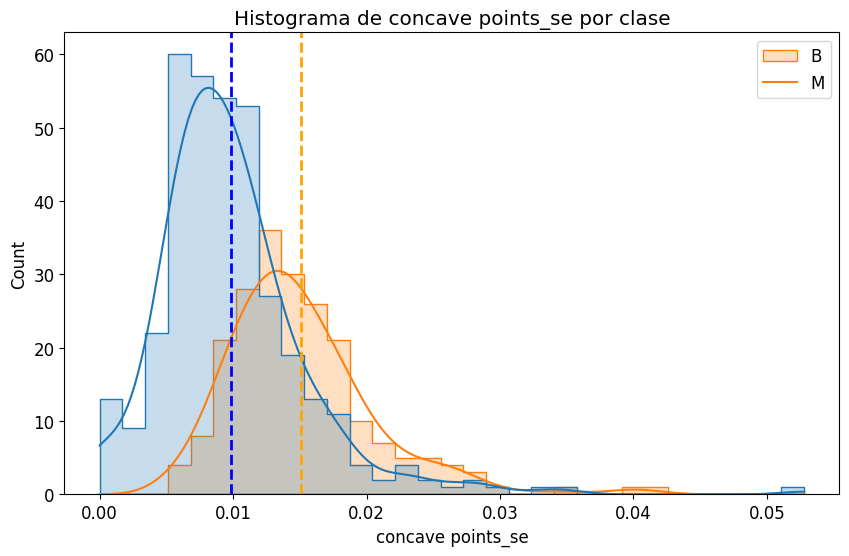

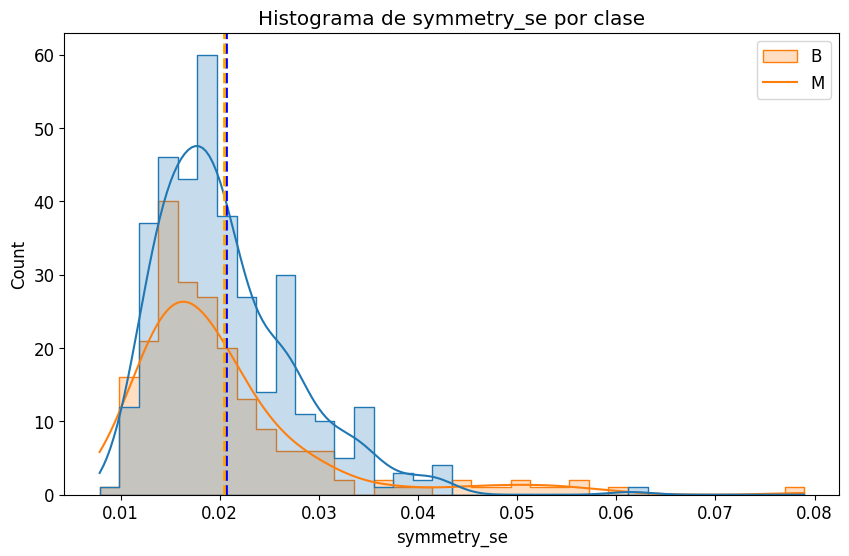

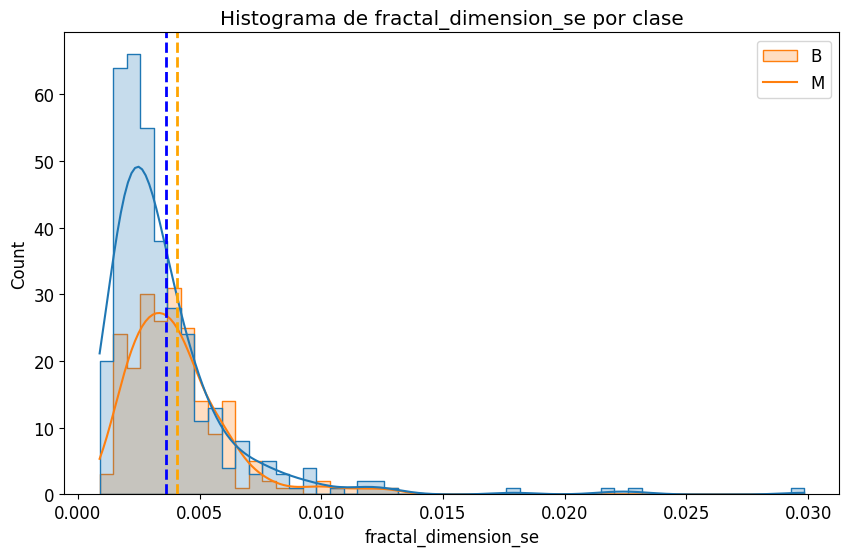

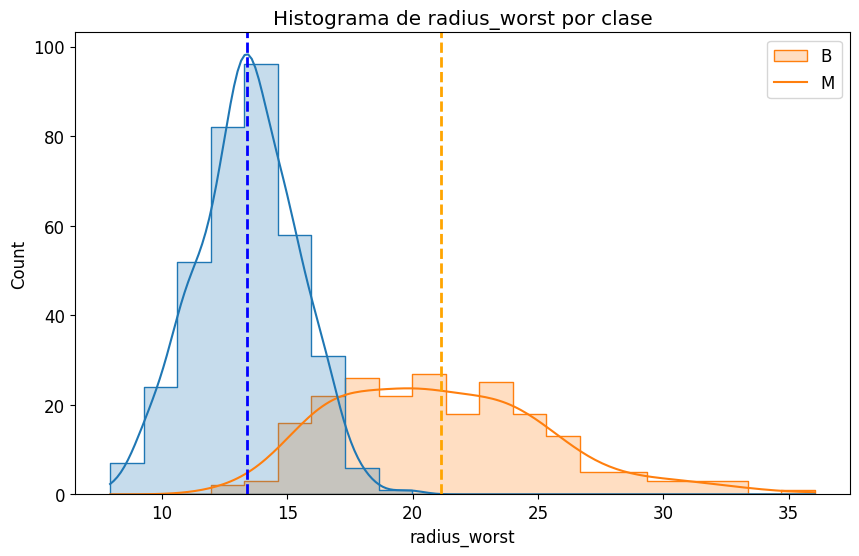

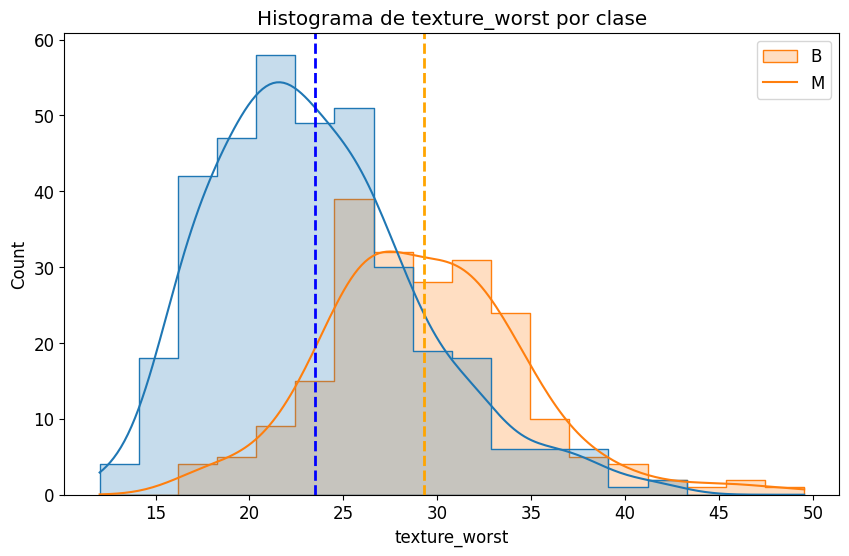

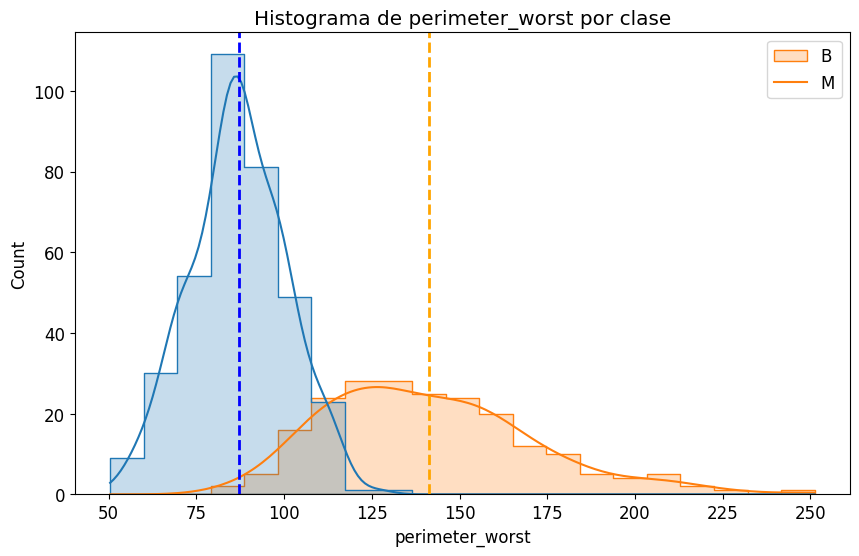

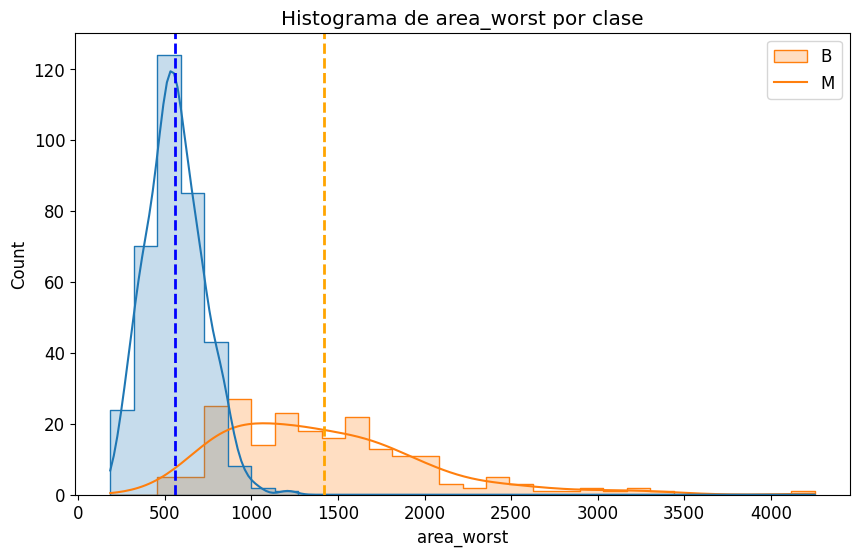

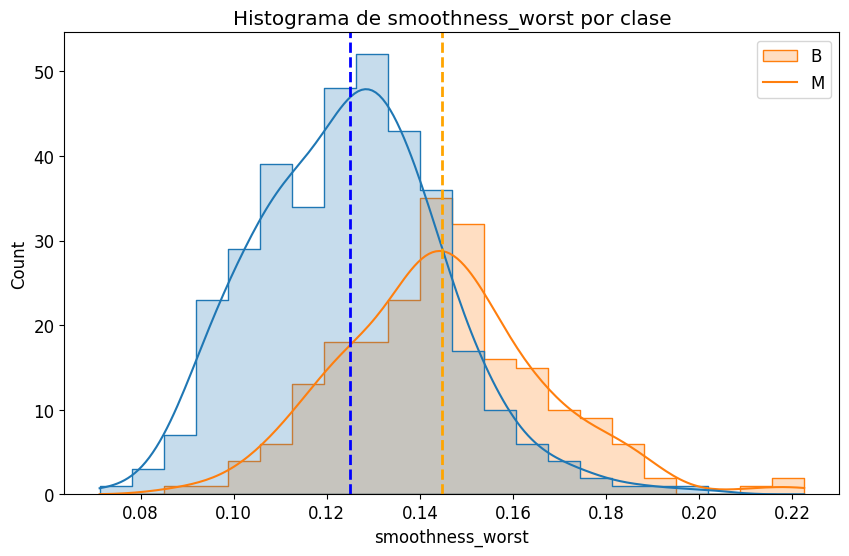

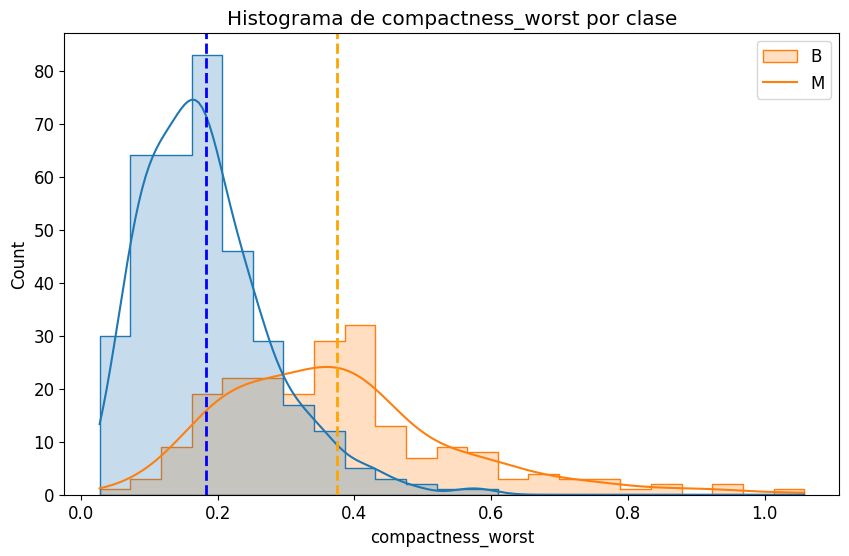

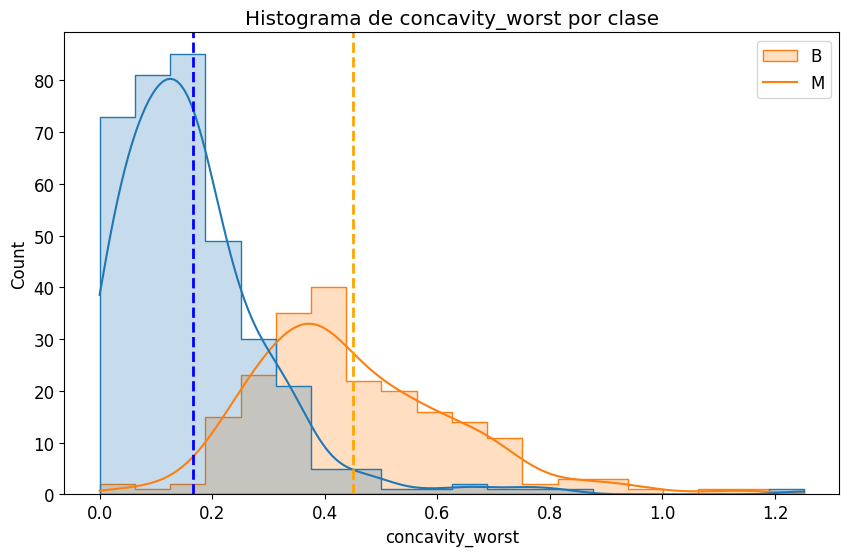

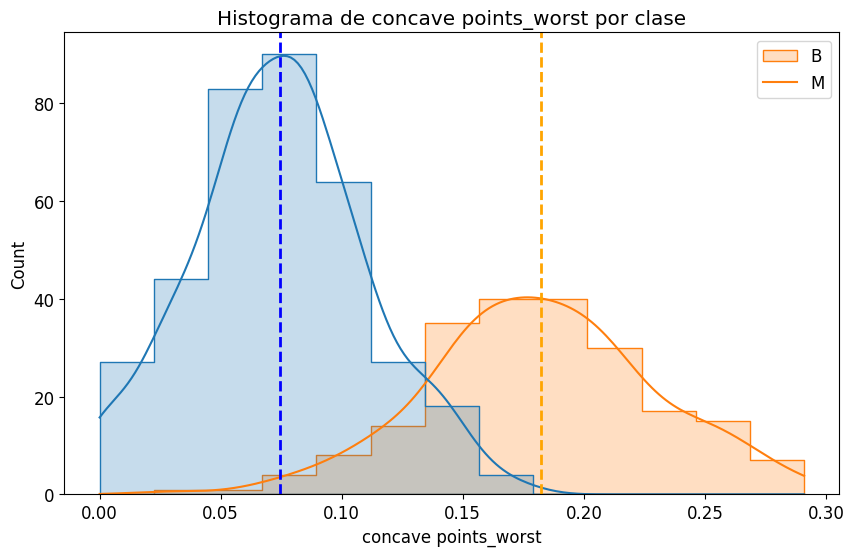

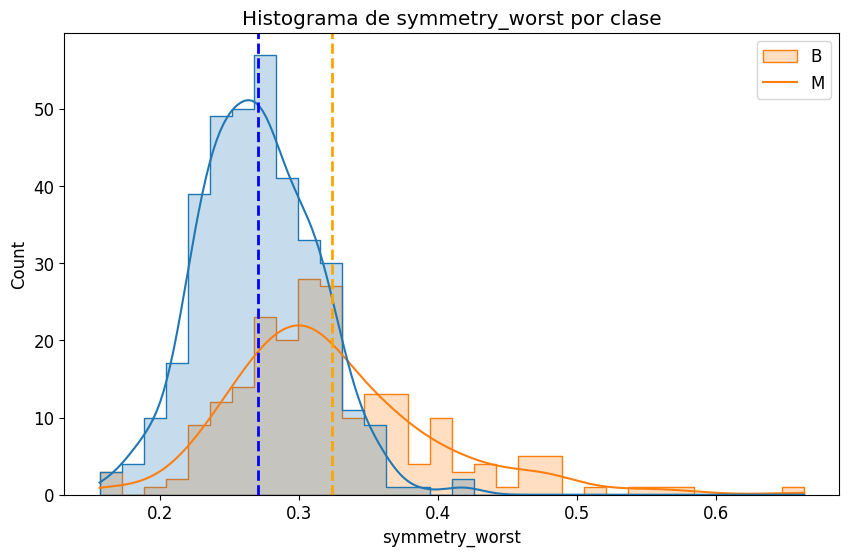

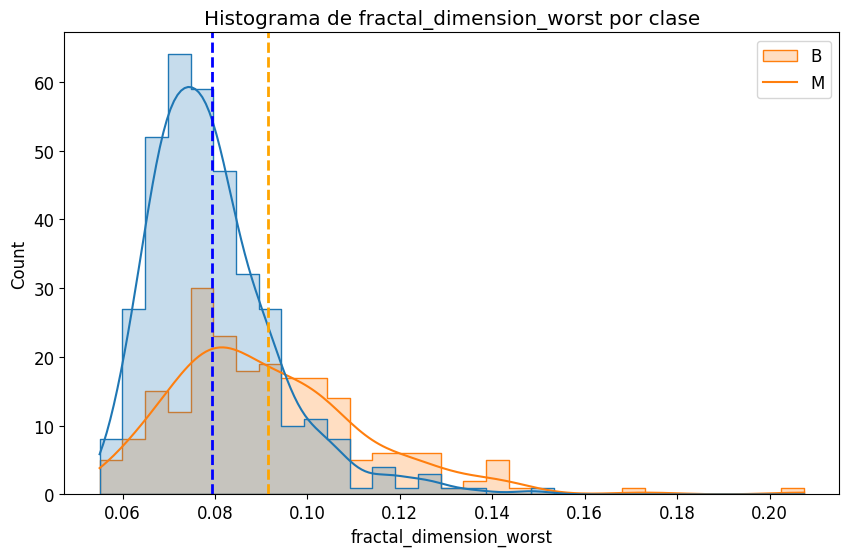

In [11]:
for feature in df.columns[1:]:
    plt.figure()
    sns.histplot(data=df, x=feature, hue='diagnosis', kde=True, element='step')
    plt.axvline(df[df['diagnosis'] == 0][feature].mean(), color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(df[df['diagnosis'] == 1][feature].mean(), color='orange', linestyle='dashed', linewidth=2)
    plt.legend(['B', 'M'])
    plt.title(f'Histograma de {feature} por clase')

### Estimando el porcentaje de overlap en los atributos
- Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvia es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.

- El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

```python
def histogram_overlap (df, attribute, target, perc= 100 ):
  # get lower bound
  empirical_lower_bound = np.floor(df[attribute].min())
  # get upper bound
  empirical_upper_bound = np.ceil(df[attribute].max())
  # preserve histograms
  tmp_hist_holder = dict()
  # for each target class
  for unique_value in np.unique(df[target]):
    # get histogram
    tmp, _ = np.histogram(
      # for a specific attribute
      df[df[target] == unique_value][attribute],
      # define percentage
      bins=perc,
      # limit empirical range for comparison
      range=[empirical_lower_bound, empirical_upper_bound]
    )
    # append to dict
    tmp_hist_holder[ "h_" +str(unique_value)] = tmp
  get_minima = np.minimum(tmp_hist_holder[ "h_1" ], tmp_hist_holder[ "h_0" ])
  intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder[ "h_0" ]))
  return intersection
```

- La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde
mayores niveles indican una mayor comunalidad.
- Utilizando la función, generará un data frame donde almacenará el nombre del atributo y
su porcentaje. Ordene este data frame de forma descendente y preserve.



In [12]:
def histogram_overlap(df, attribute, target, perc=100):
    empirical_lower_bound = np.floor(df[attribute].min())
    empirical_upper_bound = np.ceil(df[attribute].max())
    tmp_hist_holder = dict()
    for unique_value in np.unique(df[target]):
        tmp, _ = np.histogram(
            df[df[target] == unique_value][attribute],
            bins=perc,
            range=[empirical_lower_bound, empirical_upper_bound]
        )
        tmp_hist_holder["h_" + str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder["h_0"]))
    return intersection

overlap_df = pd.DataFrame(columns=['Attribute', 'Overlap'])
for attribute in df.columns[1:]:
    overlap = histogram_overlap(df, attribute, 'diagnosis')
    overlap_df = overlap_df.append({'Attribute': attribute, 'Overlap': overlap}, ignore_index=True)

overlap_df = overlap_df.sort_values('Overlap', ascending=False)

C:\Users\javit\AppData\Local\Temp\ipykernel_8180\3317033950.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df = overlap_df.append({'Attribute': attribute, 'Overlap': overlap}, ignore_index=True)
C:\Users\javit\AppData\Local\Temp\ipykernel_8180\3317033950.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df = overlap_df.append({'Attribute': attribute, 'Overlap': overlap}, ignore_index=True)
C:\Users\javit\AppData\Local\Temp\ipykernel_8180\3317033950.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overlap_df = overlap_df.append({'Attribute': attribute, 'Overlap': overlap}, ignore_index=True)
C:\Users\javit\AppData\Local\Temp\ipykernel_8180\3317033950.py:19: FutureWarning: The frame.append method 

### Selección del modelo por GridSearchCV
- Se entrena una serie de modelos SVC con los siguientes hiper parámetros:
  + `C: [ 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000 ]`.
  + `gamma: [ 0.0000001 , 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 ]`.
  + Validaciones cruzadas: 10.
- Se genera un heatmap en base a los puntajes estimados con `GridSearchCV`.

*Tip: Vea cómo acceder a la llave mean_test_score en el diccionario `cv_results_`.*

### Un par de elementos a considerar en la implementación de `GridSearchCV`.

Si trabajamos con `sklearn.model_selection.GridSearchCV`, tan solo haciendo la división en dos muestras es suficiente, incorporando los conjuntos X_train y y_train a nuestro objeto instanciado y preservando X_test e y_test como una muestra de validación externa. Si tenemos un archivo de testing externo, se recomienda no hacer división.

- El objeto creado con `sklearn.model_selection.GridSearchCV` sigue la misma funcionalidad de cualquier método de estimación de `scikit-learn`, con los pasos de Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
  + `sklearn.model_selection.GridSearchCV.cv_results_` devolverá un diccionario donde las llaves representarán distintas métricas y los valores representarán el desempeño de cada modelo.
  + `split` : Indicará la métrica específica en cada validación cruzada y combinación de hiper parámetros.
  + `time` : Indicará el tiempo de ejecución en cada modelo.
  + Por lo general trabajaremos con mean_test_score y mean_train_score que
representa la media de CV para cada combinación de hiper parámetros.
  + `sklearn.model_selection.GridSearchCV.best_estimator_` devuelve un
modelo listo para entrenar con la mejor combinación de hiper parámetros.
  + `sklearn.model_selection.GridSearchCV.best_score_` devuelve el
desempeño promedio del modelo en el testing interno. Si es un problema de
clasificación devolverá `Accuracy`, si es un problema de regresión devolverá `MSE`.

- Reporte en qué rango de cada hiper parámetro el modelo presenta un desempeño eficiente. Reporte la mejor combinación de hiper parámetros y el desempeño en la muestra de entrenamiento.

In [13]:
X = df.iloc[:, 1:]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

svc = SVC(kernel='rbf')
grid_search = GridSearchCV(svc, param_grid, cv=10)
grid_search.fit(X_train, y_train)

cv_results = grid_search.cv_results_


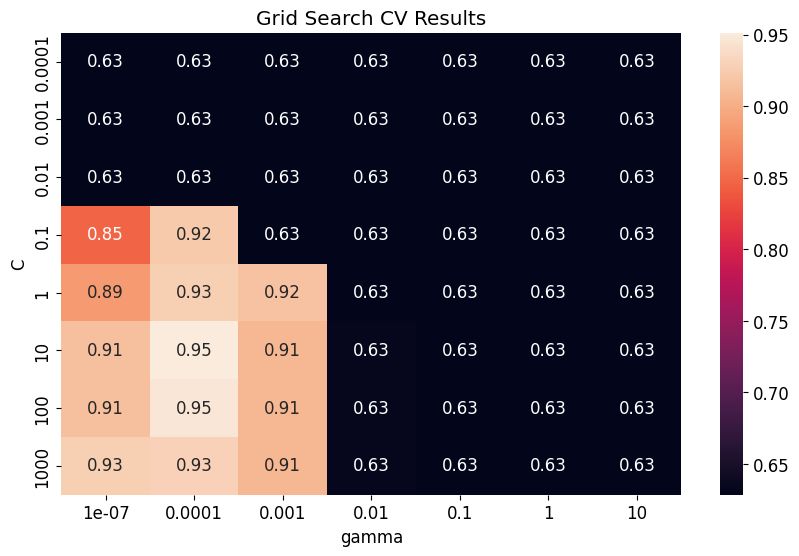

In [14]:
mean_test_score = cv_results['mean_test_score']
scores = np.array(mean_test_score).reshape(len(param_grid['C']), len(param_grid['gamma']))

sns.heatmap(scores, annot=True, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'])
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Grid Search CV Results')
plt.show()


## Validación del modelo en el hold-out sample

- Se genera las predicciones del hold-out sample en base a la mejor combinación de hiper parámetros. Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente.

In [15]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        71
           1       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



### Depuración de atributos

- Se reentrena el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45.


In [16]:
selected_features = overlap_df[overlap_df['Overlap'] < 0.45]['Attribute'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

grid_search_selected = GridSearchCV(svc, param_grid, cv=10)
grid_search_selected.fit(X_train_selected, y_train)

best_model_selected = grid_search_selected.best_estimator_
y_pred_selected = best_model_selected.predict(X_test_selected)
print(classification_report(y_test, y_pred_selected))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        71
           1       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

